In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import fmod
from scipy.interpolate import interp1d

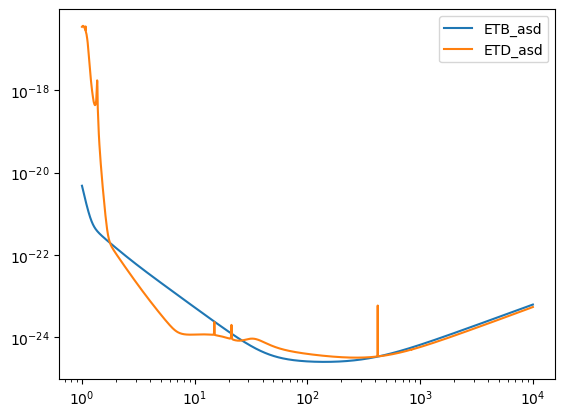

In [2]:
ETBasd=np.loadtxt('ET_B_asd.txt')
ETDasd=np.loadtxt('ET_D_asd.txt')
plt.plot(ETBasd[:,0],ETBasd[:,1],label='ETB_asd')
plt.plot(ETDasd[:,0],ETDasd[:,1],label='ETD_asd')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [3]:
speed_of_light = 299792458.0  # m/s
parsec = 3.085677581491367e+16  # m
solar_mass = 1.9884099021470415e+30  # Kg
radius_of_earth = 6378136.6  # m
gravitational_constant = 6.6743e-11  # m^3 kg^-1 s^-2

_TOL = 14

length = 10
minimum_frequency_given = 10
maximum_frequency_given  = 2048
latitude = 43 + 37. / 60 + 53.0921 / 3600
longitude = 10 + 30. / 60 + 16.1878 / 3600
elevation = 51.884
xarm_azimuth = 70.5674
yarm_azimuth = 130.5674

In [4]:
def gps_time_to_gmst(gps_time):
    omega_earth = 2 * np.pi * (1 / 365.2425 + 1) / 86400.
    gps_2000 = 630720013.
    gmst_2000 = (6 + 39. / 60 + 51.251406103947375 / 3600) * np.pi / 12
    correction_2018 = -0.00017782487379358614
    sidereal_time = omega_earth * (gps_time - gps_2000) + gmst_2000 + correction_2018
    gmst = fmod(sidereal_time, 2 * np.pi)
    return gmst

def ra_dec_to_theta_phi(ra, dec, gmst):
    phi = ra - gmst
    theta = np.pi / 2 - dec
    return theta, phi

def get_polarization_tensor(ra, dec, time, psi, mode):
    gmst = gps_time_to_gmst(time)
    theta, phi = ra_dec_to_theta_phi(ra, dec, gmst)
    u = np.array([np.cos(phi) * np.cos(theta), np.cos(theta) * np.sin(phi), -np.sin(theta)])
    v = np.array([-np.sin(phi), np.cos(phi), 0])
    m = -u * np.sin(psi) - v * np.cos(psi)
    n = -u * np.cos(psi) + v * np.sin(psi)

    if mode.lower() == 'plus':
        return np.einsum('i,j->ij', m, m) - np.einsum('i,j->ij', n, n)
    elif mode.lower() == 'cross':
        return np.einsum('i,j->ij', m, n) + np.einsum('i,j->ij', n, m)
    elif mode.lower() == 'breathing':
        return np.einsum('i,j->ij', m, m) + np.einsum('i,j->ij', n, n)
    omega = np.cross(m, n)
    if mode.lower() == 'longitudinal':
        return np.einsum('i,j->ij', omega, omega)
    elif mode.lower() == 'x':
        return np.einsum('i,j->ij', m, omega) + np.einsum('i,j->ij', omega, m)
    elif mode.lower() == 'y':
        return np.einsum('i,j->ij', n, omega) + np.einsum('i,j->ij', omega, n)
    else:
        raise ValueError("{} not a polarization mode!".format(mode))
def calculate_arm(latitude,longitude,arm_tilt, arm_azimuth):
    e_long = np.array([-np.sin(longitude), np.cos(longitude), 0])
    e_lat = np.array([-np.sin(latitude) * np.cos(longitude),
                      -np.sin(latitude) * np.sin(longitude), np.cos(latitude)])
    e_h = np.array([np.cos(latitude) * np.cos(longitude),
                    np.cos(latitude) * np.sin(longitude), np.sin(latitude)])
    return (np.cos(arm_tilt) * np.cos(arm_azimuth) * e_long +
            np.cos(arm_tilt) * np.sin(arm_azimuth) * e_lat +
            np.sin(arm_tilt) * e_h)
def detector_tensor():
    xarm_azimuth2=xarm_azimuth * np.pi / 180
    yxarm_azimuth2=yarm_azimuth * np.pi / 180
    xarm_tilt=0.
    yarm_tilt=0
    x=calculate_arm(latitude,longitude,xarm_tilt, xarm_azimuth2)
    y=calculate_arm(latitude,longitude,yarm_tilt, yxarm_azimuth2)
    return 0.5 * (np.einsum('i,j->ij', x, x) - np.einsum('i,j->ij', y, y))

def get_vertex_position_geocentric(latitude, longitude, elevation):
    semi_major_axis = 6378137  # for ellipsoid model of Earth, in m
    semi_minor_axis = 6356752.314  # in m
    radius = semi_major_axis**2 * (semi_major_axis**2 * np.cos(latitude)**2 +
                                   semi_minor_axis**2 * np.sin(latitude)**2)**(-0.5)
    x_comp = (radius + elevation) * np.cos(latitude) * np.cos(longitude)
    y_comp = (radius + elevation) * np.cos(latitude) * np.sin(longitude)
    z_comp = ((semi_minor_axis / semi_major_axis)**2 * radius + elevation) * np.sin(latitude)
    return np.array([x_comp, y_comp, z_comp])

def antenna_response(ra, dec, time, psi, mode):
    polarization_tensor = get_polarization_tensor(ra, dec, time, psi, mode)
    return np.einsum('ij,ij->', detector_tensor(), polarization_tensor)
def _check_legal_sampling_frequency_and_duration(sampling_frequency, duration):
    num = sampling_frequency * duration
    if np.abs(num - np.round(num)) > 10**(-_TOL):
        raise IllegalDurationAndSamplingFrequencyException(
            '\nYour sampling frequency and duration must multiply to a number'
            'up to (tol = {}) decimals close to an integer number. '
            '\nBut sampling_frequency={} and  duration={} multiply to {}'.format(
                _TOL, sampling_frequency, duration,
                sampling_frequency * duration
            )
        )

In [5]:
def create_frequency_series(sampling_frequency, duration):
#     _check_legal_sampling_frequency_and_duration(sampling_frequency, duration)
    number_of_samples = int(np.round(duration * sampling_frequency))
    number_of_frequencies = int(np.round(number_of_samples / 2) + 1)
    return np.linspace(start=0,stop=sampling_frequency / 2,num=number_of_frequencies)


def create_time_series(sampling_frequency, duration, starting_time=0.):
#     _check_legal_sampling_frequency_and_duration(sampling_frequency, duration)
    number_of_samples = int(duration * sampling_frequency)
    return np.linspace(start=starting_time,
                       stop=duration + starting_time - 1 / sampling_frequency,
                       num=number_of_samples)

def time_delay_geocentric(detector1, detector2, ra, dec, time):
    gmst = gps_time_to_gmst(time)
    theta, phi = ra_dec_to_theta_phi(ra, dec, gmst)
    omega = np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)])
    delta_d = detector2 - detector1
    return np.dot(omega, delta_d) / speed_of_light

def get_detector_response(ra,dec,time,psi,waveform_polarizations):
    signal = {}
    for mode in waveform_polarizations.keys(): #The waveform should like {"plus":np.array([0,1,2,...]),"cross":np.array([0,1,2,...])}
        det_response = antenna_response(ra,dec,time,psi, mode)

        signal[mode] = waveform_polarizations[mode] * det_response
    signal_ifo = sum(signal.values())

    signal_ifo *= frequency_mask

    dt = time_delay_geocentric(vertex, np.array([0, 0, 0]), ra, dec, time)
    
    return signal_ifo[frequency_mask] * np.exp(-1j * 2 * np.pi * dt * frequency_array[frequency_mask])

def optimal_snr_squared(signal, power_spectral_density, duration):
    return noise_weighted_inner_product(signal, signal, power_spectral_density, duration)

def noise_weighted_inner_product(aa, bb, power_spectral_density, duration):
    integrand = np.conj(aa) * bb / power_spectral_density
    return 4 / duration * np.sum(integrand)

def nfft(time_domain_strain, sampling_frequency):
    frequency_domain_strain = np.fft.rfft(time_domain_strain)
    frequency_domain_strain /= sampling_frequency

    frequency_array = np.linspace(0, sampling_frequency / 2, len(frequency_domain_strain))

    return frequency_domain_strain, frequency_array

[83.85657414 78.10732155]
96 0.009550230774464166 0.05294072071539217


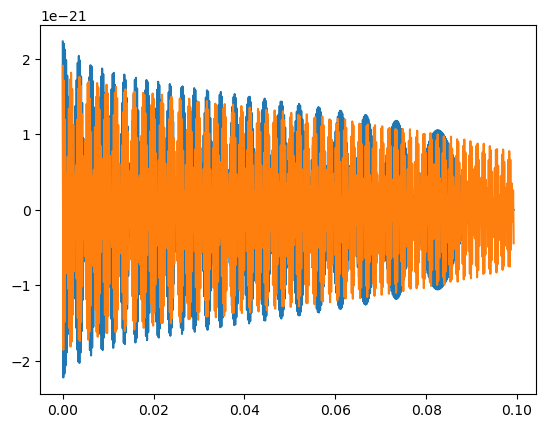

In [23]:
sampling_frequency=2048*4
maximum_frequency=2048*2
MSUN = 1.988409902147041e30 # kg

iota=np.pi/3
mp=1e-3
magnitude = -round(np.log10(mp))

dl=1e4*parsec
phi0=0.0


model0 = 1
model1 = 2

mrdata0 = np.loadtxt("model%dm.txt"%model0)
f0 = interp1d(mrdata0[:, 0], mrdata0[:, 1])
mrdata1 = np.loadtxt("model%dm.txt"%model1)
f1 = interp1d(mrdata1[:, 0], mrdata1[:, 1])

orbit=np.loadtxt('Mm%d_orbit_model%d.txt'%(magnitude, model0))
rt=interp1d(orbit[:,0],orbit[:,1],kind='cubic')
mt=interp1d(orbit[:,0],orbit[:,2]/MSUN,kind='cubic')
phit=interp1d(orbit[:,0],orbit[:,3],kind='cubic')
omegat=interp1d(orbit[:,0],orbit[:,4],kind='cubic')

orbit1=np.loadtxt('Mm%d_orbit_model%d.txt'%(magnitude, model1))
rt1=interp1d(orbit1[:,0],orbit1[:,1],kind='cubic')
mt1=interp1d(orbit1[:,0],orbit1[:,2]/MSUN,kind='cubic')
phit1=interp1d(orbit1[:,0],orbit1[:,3],kind='cubic')
omegat1=interp1d(orbit1[:,0],orbit1[:,4],kind='cubic')


duration=np.loadtxt('Mm%d_orbit_model2.txt'%(magnitude))[:, 0][-1]
# duration=np.min([orbit[:, 0][np.argwhere(orbit[:,1]>1e3)[-1][0]], orbit1[:,0][np.argwhere(orbit1[:,1]>1e3)[-1][0]]])



time_array=create_time_series(sampling_frequency, duration, starting_time=0.)

unit1 = solar_mass*gravitational_constant/speed_of_light**2
unit2 = gravitational_constant/speed_of_light**3

plus_time_domain0 = np.zeros(time_array.shape[0])
cross_time_domain0 = np.zeros(time_array.shape[0])
plus_time_domain1 = np.zeros(time_array.shape[0])
cross_time_domain1 = np.zeros(time_array.shape[0])

index0 = np.where(time_array<orbit[-1, 0])
time_array0 = time_array[index0]
plus_time_domain0[index0]=(1+np.cos(iota)**2)/2*np.cos(2*phit(time_array0)+2*phi0)*unit1*4*mt(time_array0)*(unit2*f0(rt(time_array0))*omegat(time_array0))**(2/3)/dl
cross_time_domain0[index0]=-np.cos(iota)*np.sin(2*phit(time_array0)+2*phi0)*unit1*4*mt(time_array0)*(unit2*f0(rt(time_array0))*omegat(time_array0))**(2/3)/dl

index1 = np.where(time_array<orbit1[-1, 0])
time_array1 = time_array[index1]
plus_time_domain1[index1]=(1+np.cos(iota)**2)/2*np.cos(2*phit1(time_array1)+2*phi0)*unit1*4*mt1(time_array1)*(unit2*f1(rt1(time_array1))*omegat1(time_array1))**(2/3)/dl
cross_time_domain1[index1]=-np.cos(iota)*np.sin(2*phit1(time_array1)+2*phi0)*unit1*4*mt1(time_array1)*(unit2*f1(rt1(time_array1))*omegat1(time_array1))**(2/3)/dl


plt.plot(time_array, plus_time_domain0)
plt.plot(time_array, plus_time_domain1)


if 2 * maximum_frequency_given > sampling_frequency:
    maximum_frequency= sampling_frequency / 2.
    
minimum_frequency=minimum_frequency_given

#If the waveform is in time-domain frequency
plus_frequency_domain0,frequency_array=nfft(time_domain_strain=plus_time_domain0,sampling_frequency=sampling_frequency)
cross_frequency_domain0,frequency_array=nfft(time_domain_strain=cross_time_domain0,sampling_frequency=sampling_frequency)

plus_frequency_domain1,frequency_array=nfft(time_domain_strain=plus_time_domain1,sampling_frequency=sampling_frequency)
cross_frequency_domain1,frequency_array=nfft(time_domain_strain=cross_time_domain1,sampling_frequency=sampling_frequency)

# frequency_array = create_frequency_series(sampling_frequency,duration)

frequency_mask = ((frequency_array >= minimum_frequency) & (frequency_array <= maximum_frequency)) 

vertex=get_vertex_position_geocentric(latitude, longitude, elevation)

power_spectral_density_interpolated = interp1d(ETDasd[:,0],ETDasd[:,1]**2,bounds_error=False,fill_value=np.inf)
power_spectral_density=power_spectral_density_interpolated(frequency_array[frequency_mask])


waveform_polarizations0={"plus":plus_frequency_domain0,"cross":cross_frequency_domain0}
waveform_polarizations1={"plus":plus_frequency_domain1,"cross":cross_frequency_domain1}

# We need two waveform including plus and cross for different models in frequency domain
# waveform_polarizations1={"plus":frequency_array,"cross":frequency_array}
# waveform_polarizations2={"plus":frequency_array,"cross":frequency_array}
ra=np.pi/3
dec=np.pi/3
time=0.0
psi=0
signal0=get_detector_response(ra,dec,time,psi,waveform_polarizations0)
signal1=get_detector_response(ra,dec,time,psi,waveform_polarizations1)


snr_square0=optimal_snr_squared(signal=signal0,power_spectral_density=power_spectral_density,duration=duration)
snr_square1=optimal_snr_squared(signal=signal1,power_spectral_density=power_spectral_density,duration=duration)
print(np.real([snr_square0**0.5, snr_square1**0.5]))

t0list=np.linspace(0, duration, 1000)
overlaplist=[]
for t0 in t0list:
    phaset0=np.exp(1j*2*np.pi*frequency_array[frequency_mask]*t0)
    overlap=noise_weighted_inner_product(signal0*phaset0,signal1,power_spectral_density,duration=duration)/np.sqrt(snr_square0*snr_square1)
    overlaplist.append(overlap)
print(np.argmax(np.abs(overlaplist)), t0list[np.argmax(np.abs(overlaplist))], np.max(np.abs(overlaplist)))